In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.linear_model import LogisticRegression
from keras.preprocessing.sequence import pad_sequences
from keras.backend import clear_session
from keras.preprocessing.text import Tokenizer
from sklearn import preprocessing
from tensorflow import keras
from keras import layers, Sequential

In [23]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


In [24]:
le = preprocessing.LabelEncoder()
yes_df_emb = pd.read_csv('data/yes_emotion.csv')

label = le.fit_transform(yes_df_emb['sentiment'].values)
corpus = yes_df_emb['content'].values


sentences_train, sentences_test, y_train, y_test = train_test_split(
                                    corpus, label, test_size=0.25, random_state=1000)


In [25]:
vectorizer = CountVectorizer(strip_accents = "ascii", stop_words='english')
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

X_test = X_test.sorted_indices()
X_train = X_train.sorted_indices()

classifier = LogisticRegression(max_iter=500)
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print(f'Accuracy for yes_emb data: {score*100}%')

Accuracy for yes_emb data: 34.150000000000006%


In [26]:
input_dim = X_train.shape[1] 

model = Sequential()
model.add(layers.Dense(10, input_dim = input_dim, activation = 'relu'))
model.add(layers.Dense(13, input_dim = input_dim, activation = 'softmax'))
model.compile(loss='sparse_categorical_crossentropy',
                optimizer = 'adam',
                metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                390520    
_________________________________________________________________
dense_1 (Dense)              (None, 13)                143       
Total params: 390,663
Trainable params: 390,663
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(X_train, y_train,
                    epochs = 10,
                    verbose=True,
                    validation_data=(X_test,y_test),
                    batch_size=126)

Epoch 1/10
239/239 [==============================] - 1s 3ms/step - loss: 2.4712 - accuracy: 0.2316 - val_loss: 2.1298 - val_accuracy: 0.2975
Epoch 2/10
239/239 [==============================] - 1s 2ms/step - loss: 2.0094 - accuracy: 0.3625 - val_loss: 1.9922 - val_accuracy: 0.3323
Epoch 3/10
239/239 [==============================] - 1s 2ms/step - loss: 1.7656 - accuracy: 0.4426 - val_loss: 1.9445 - val_accuracy: 0.3458
Epoch 4/10
239/239 [==============================] - 1s 2ms/step - loss: 1.5919 - accuracy: 0.5029 - val_loss: 1.9344 - val_accuracy: 0.3517
Epoch 5/10
239/239 [==============================] - 1s 2ms/step - loss: 1.4025 - accuracy: 0.5696 - val_loss: 1.9484 - val_accuracy: 0.3497
Epoch 6/10
239/239 [==============================] - 1s 2ms/step - loss: 1.2314 - accuracy: 0.6329 - val_loss: 1.9770 - val_accuracy: 0.3455
Epoch 7/10
239/239 [==============================] - 1s 2ms/step - loss: 1.0667 - accuracy: 0.6949 - val_loss: 2.0176 - val_accuracy: 0.3409
Epoch 

In [28]:
clear_session()

In [29]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8476
Testing Accuracy:  0.3229


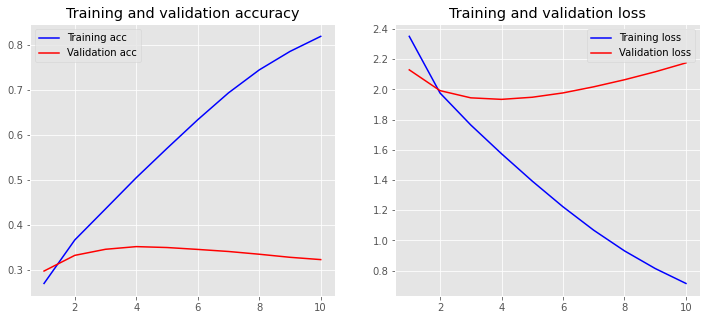

In [30]:
plot_history(history)

In [53]:
tokenizer = Tokenizer(num_words=5000,filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[4])
print(X_train[2])

@halbpro it's called retro my dear and I wear fifties fashion sometimes....did you not see my birthday pictures?
[4, 128, 983, 133]


In [42]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[4535   52  620    2  979    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [43]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(13, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           2400300   
_________________________________________________________________
flatten_2 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               500100    
_________________________________________________________________
dense_5 (Dense)              (None, 13)                1313      
Total params: 2,901,713
Trainable params: 2,901,713
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
239/239 [==============================] - 6s 22ms/step - loss: 2.1519 - accuracy: 0.2465 - val_loss: 2.0061 - val_accuracy: 0.3036
Epoch 2/10
239/239 [==============================] - 5s 22ms/step - loss: 1.9149 - accuracy: 0.3511 - val_loss: 1.9482 - val_accuracy: 0.3316
Epoch 3/10
239/239 [==============================] - 5s 21ms/step - loss: 1.7514 - accuracy: 0.4140 - val_loss: 1.9617 - val_accuracy: 0.3340
Epoch 4/10
239/239 [==============================] - 5s 21ms/step - loss: 1.5754 - accuracy: 0.4871 - val_loss: 2.0438 - val_accuracy: 0.3236
Epoch 5/10
239/239 [==============================] - 5s 21ms/step - loss: 1.3371 - accuracy: 0.5747 - val_loss: 2.2275 - val_accuracy: 0.3132
Epoch 6/10
239/239 [==============================] - 5s 23ms/step - loss: 1.0654 - accuracy: 0.6770 - val_loss: 2.4714 - val_accuracy: 0.2969
Epoch 7/10
239/239 [==============================] - 5s 22ms/step - loss: 0.8236 - accuracy: 0.7565 - val_loss: 2.7651 - val_accuracy: 0.2844

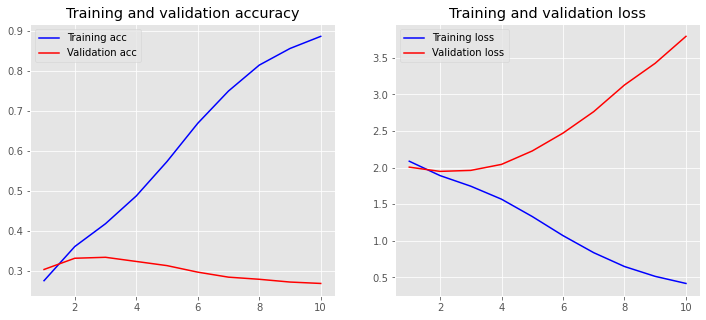

In [44]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=126)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))



In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

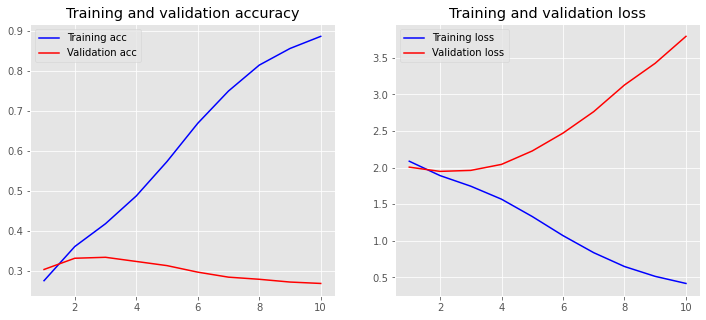

In [45]:
plot_history(history)